# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
날씨 데이터 세트

Max Planck Institute for Biogeochemistry에 의해 기록 된 [날씨 시계열 데이터 세트]를 사용

대기 온도, 대기압 및 습도와 같은 14 가지 특징으로 구성
2009 년과 2016 년 사이에 수집 된 데이터 만 사용

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

C:\Users\hjsong\.keras\datasets\jena_climate_2009_2016.csv


In [3]:
#pandas dataframe으로 csv파일 read
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [4]:
# 상위 데이터 목록 확인
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


10 분마다 기록된 데이터 (한 시간 동안 6 개의 관측 값), 하루에 144 개 (6x24)의 관측치가 포함
특정 시간이 주어지면 앞으로 6 시간 동안 온도를 예측
이 예측을하기 위해 5 일간의 관찰을 사용하도록 선택
학습을 위해 마지막 720 (5x144) 관측 값이 포함 된 window를 만들어 적용

데이터의 처음 300,000 개 행은 학습 데이터 세트(2100일 분량)이고 나머지는 유효성 검사 데이터 세트로 구성

In [5]:
TRAIN_SPLIT = 300000

재현성을 보장하기 위해 시드 설정.

In [6]:
tf.random.set_seed(13)

In [7]:
def create_time_steps(length):
  return list(range(-length, 0))

In [8]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

## Part 2: Forecast a multivariate time series

3개의 특징(온도, 대기압 및 공기 밀도)로  온도예측


### (1)3개의 특징만 추출

In [9]:

features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [10]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001006B2E8>,
      dtype=object)

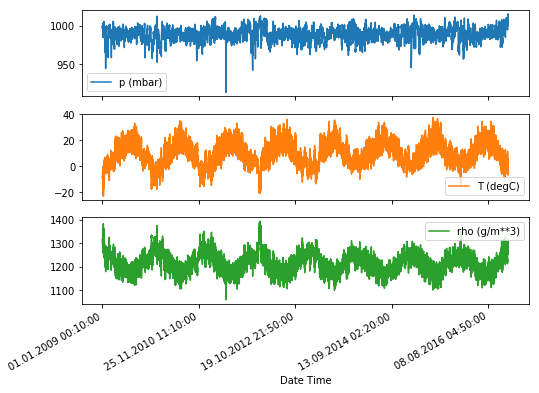

In [11]:
features.plot(subplots=True)

### (2) 표준화 


In [12]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [13]:
dataset = (dataset-data_mean)/data_std

### (3)학습데이터 생성함수 (window)

In [14]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

## Multi-Step model
다단계 예측 모델에서 과거 히스토리가 주어지면 모델은 미래의 값 범위를 예측하는 법을 학습
단일 미래 포인트 만 예측되는 단일 단계 모델과 달리 다단계 모델은 미래의 시퀀스를 예측

다단계 모델의 경우 훈련 데이터는 다시 한 시간마다 샘플링 된 지난 5 일 동안의 기록으로 구성, 12 시간 동안 온도를 예측하는 방법을 학습
10 분마다 관측이 수행되므로 결과는 72 개의 예측


### (5)윈도우 크기에 따른  학습데이터, 테스트 데이터 추출

In [15]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP, single_step=False)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, single_step=False)

sample data-point 확인

In [16]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [17]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

### (6) 다단계 예측 모델 Plotting

In [18]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

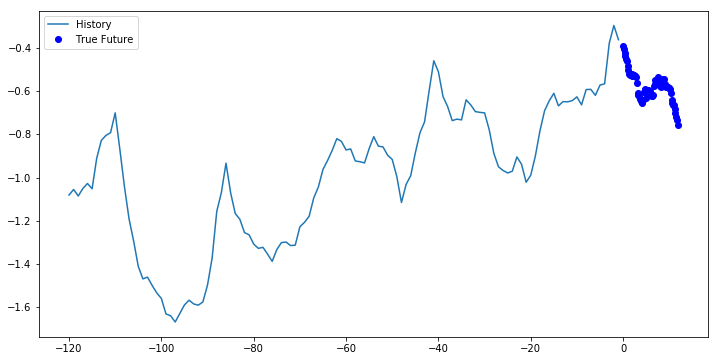

In [19]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

### (7)모델 구성

다단계 예측모델은 이전 작업보다 약간 복잡하기 때문에 두 개의 LSTM 계층으로 구성  
마지막 layer에서는 72 개의 예측을 출력

In [20]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

학습하기 전 모델 예측 확인

In [21]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


### (8)모델 학습

In [22]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 40s 198ms/step - loss: 0.5384 - val_loss: 0.3247
Epoch 2/10
200/200 [==============================] - 39s 197ms/step - loss: 0.3353 - val_loss: 0.2774
Epoch 3/10
200/200 [==============================] - 46s 229ms/step - loss: 0.3091 - val_loss: 0.2620
Epoch 4/10
200/200 [==============================] - 41s 203ms/step - loss: 0.2612 - val_loss: 0.2314
Epoch 5/10
200/200 [==============================] - 43s 217ms/step - loss: 0.2108 - val_loss: 0.2085
Epoch 6/10
200/200 [==============================] - 44s 221ms/step - loss: 0.2144 - val_loss: 0.2293
Epoch 7/10
200/200 [==============================] - 39s 197ms/step - loss: 0.2077 - val_loss: 0.2076
Epoch 8/10
200/200 [==============================] - 40s 200ms/step - loss: 0.2015 - val_loss: 0.1979
Epoch 9/10
200/200 [==============================] - 40s 201ms/step - loss: 0.2035 - val_loss: 0.1922
Epoch 10/10
200/200 [=========

In [23]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

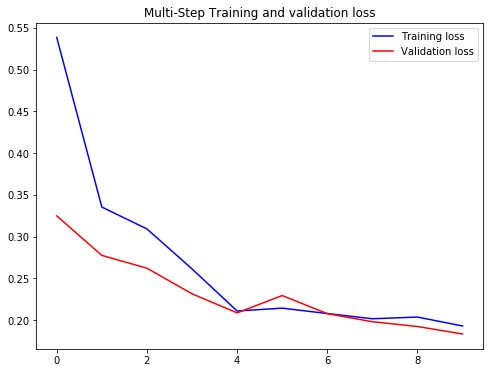

In [24]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

### (10) Predict a multi-step future
학습된 모델을 이용한 예측

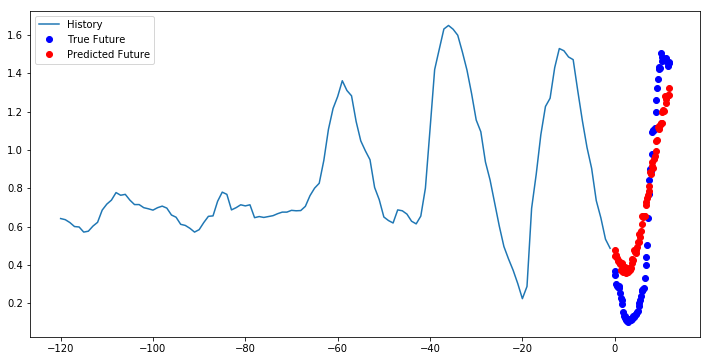

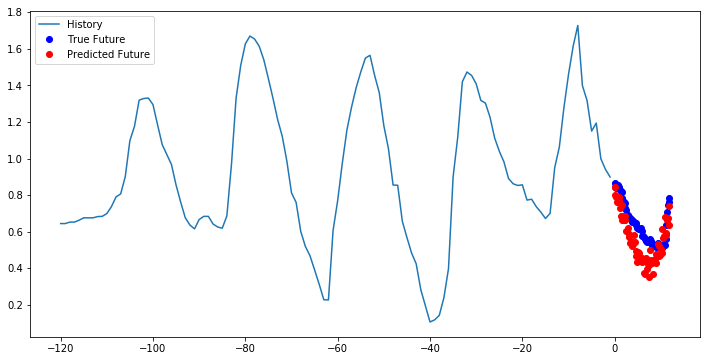

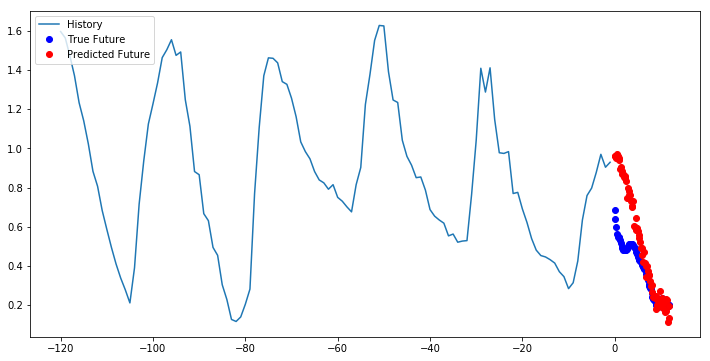

In [25]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])